In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [97]:
diamonds_df = pd.read_csv('diamonds.csv')

In [98]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


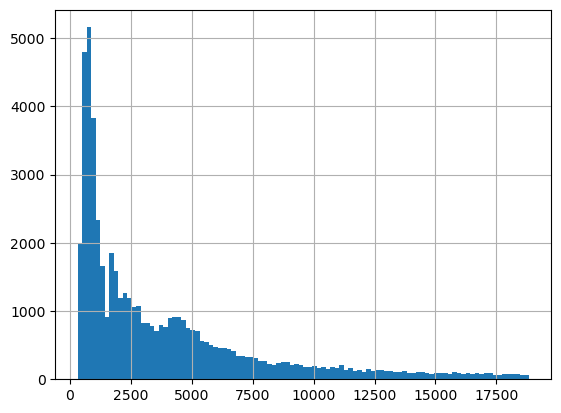

In [99]:
plt.hist(diamonds_df['price'], bins=100)
plt.grid();

# Подготовка данных

In [100]:
features = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [101]:
cut_transform = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [102]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(lambda x: clarity_transform.get(x))

In [103]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [104]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=47, test_size=0.3)

# Обучаем модель линейной регрессии

In [106]:
reg = LinearRegression().fit(X_train, y_train)

In [107]:
y_pred = reg.predict(X_test)

In [108]:
score = r2_score(y_pred, y_test)

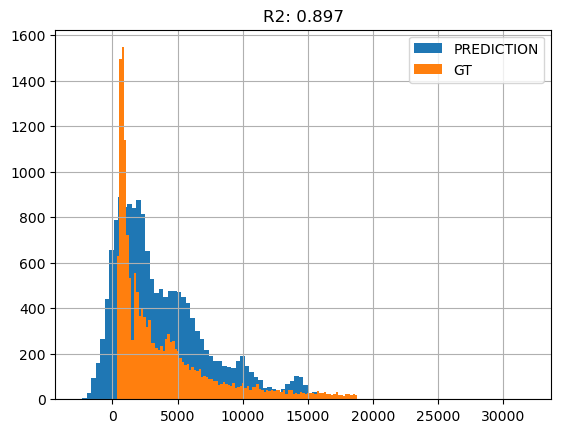

In [109]:
plt.title(f'R2: {str(score)[:5]}')
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();

# Создаём модель MLP для задачи регрессии

In [216]:
import numpy as np

class MLPRegressor:
    def __init__(self, hidden_layer_sizes=100, learning_rate=0.0000001, max_iter=1000):
        """
        Инициализация модели.
        :param hidden_layer_sizes: кортеж, задающий количество нейронов в каждом скрытом слое.
        :param learning_rate: скорость обучения.
        :param max_iter: максимальное количество итераций обучения.
        """
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter

        self.weights = []


    def _initialize_weights(self, n_features):
        layer_sizes = [n_features] + [self.hidden_layer_sizes] + [1]
        for i in range(len(layer_sizes) - 1):
            self.weights.append(np.random.uniform(-0.5, 0.5, size=(layer_sizes[i], layer_sizes[i+1])))

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _sigmoid_derivative(self, z):
        s = self._sigmoid(z)
        return s * (1 - s)

    def _forward(self, X):
        """
        Прямой проход.
        """
        activations = [X]
        inputs = []
        for i in range(len(self.weights)):
            W = self.weights[i]
            Z = np.dot(activations[-1], W) 
            inputs.append(Z)
            if i == len(self.weights) - 1:
                # для последнего, линейного слоя
                activations.append(Z)
            else:
                activations.append(self._sigmoid(Z))
        return inputs, activations

    def _backpropagation(self, inputs, activations, y):
        """
        Обратное распространение ошибки.
        """
        deltas = [2 * (activations[-1] - y)]  # Ошибка на выходном слое

        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self._sigmoid_derivative(inputs[i - 1])
            deltas.insert(0, delta)

        grad_W = [np.dot(activations[i].T, deltas[i]) for i in range(len(self.weights))]

        return grad_W

    def train(self, X, y):
        """
        Обучение модели на данных.
        """
        n_samples, n_features = X.shape
        self._initialize_weights(n_features)

        for epoch in range(self.max_iter):
            inputs, activations = self._forward(X)
            grad_W = self._backpropagation(inputs, activations, y)

            # Обновляем веса и смещения
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * grad_W[i]

            # Выводим потери каждые 10 эпох
            if epoch % 10 == 0:
                loss = np.mean((activations[-1] - y) ** 2 )
                print(f"Эпоха {epoch}, Потери: {loss}")

    def predict(self, X):
        """
        Прогноз на новых данных.
        """
        _, activations = self._forward(X)
        return activations[-1]


In [213]:
# Тестовая реализация через стоахастический градиентный спуск
class MLPRegressorSGB:
    def __init__(
        self,
        hidden_layer_sizes=(100,),
        learning_rate=0.00001,
        max_iter=10000,
    ):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter

        self.weights = []
        self.biases = []

    def _init_weights(self, n_features):
        layers = [n_features] + list(self.hidden_layer_sizes) + [1]

        for i in range(len(layers) - 1):
            self.weights.append(np.random.uniform(-0.5, 0.5, size=(layers[i+1], layers[i])))

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _sigmoid_derivative(self, z):
        s = self._sigmoid(z)
        return s * (1 - s)

    def _forward(self, input_data):
        out_layers = []
        y = None
        for idx, W_i in enumerate(self.weights):
            if idx != len(self.weights) - 1:
                summa = np.dot(W_i, input_data)
                out = np.array([self._sigmoid(_el) for _el in summa])
                out_layers.append(out)
                input_data = out
        summa = np.dot(self.weights[len(self.weights) - 1], input_data)
        out_layers.append(summa)
        y = summa
        return y, out_layers
            
    def train(self, X, y):
        n_features = X.shape[1]
        self._init_weights(n_features)
        
        for idx_iter in range(self.max_iter):
            idx = np.random.randint(0, X.shape[0])
            x_i = X[idx]
            y_i = y[idx]

            y_pred, out_layers = self._forward(x_i)
            loss = (y_i - y_pred)
            if idx_iter % 10 == 0:
                print(loss)
            grads = []
            for idx in range(len(self.weights) - 1, 0, -1):
                if idx == len(self.weights) - 1:
                    grad = loss
                    grads.insert(0, grad)
                else:
                    grad = self.weights[idx + 1] * grads[0] * out_layers[idx + 1]
                
                self.weights[idx] -= self.learning_rate * grad * out_layers[idx]

            
    
    def predict(self, X):
        pass

# Проверяем модель MLP на выборке Diamonds

In [217]:
model = MLPRegressor()
model.train(X_train, y_train)

Эпоха 0, Потери: 31511185.365665626
Эпоха 10, Потери: 15920664.668054447
Эпоха 20, Потери: 15651049.877674442
Эпоха 30, Потери: 15377656.625692507
Эпоха 40, Потери: 15569136.98036635
Эпоха 50, Потери: 15070132.78279311
Эпоха 60, Потери: 15049101.93464207
Эпоха 70, Потери: 14335586.611037986
Эпоха 80, Потери: 14657077.136331124
Эпоха 90, Потери: 13939280.91380704
Эпоха 100, Потери: 13931205.80953119
Эпоха 110, Потери: 12146704.850596292
Эпоха 120, Потери: 12955753.610540697
Эпоха 130, Потери: 11995543.378878443
Эпоха 140, Потери: 13293392.947422098
Эпоха 150, Потери: 11677771.100433014
Эпоха 160, Потери: 11320836.094212396
Эпоха 170, Потери: 10371135.453923596
Эпоха 180, Потери: 10062386.832617944
Эпоха 190, Потери: 10318379.94659876
Эпоха 200, Потери: 10289585.768296758
Эпоха 210, Потери: 9452944.179835804
Эпоха 220, Потери: 10033220.478322197
Эпоха 230, Потери: 8239876.712477938
Эпоха 240, Потери: 8640148.483758
Эпоха 250, Потери: 7554897.0032911785
Эпоха 260, Потери: 7819114.27769502

In [218]:
y_pred_mlp = model.predict(X_test)

In [219]:
score_mlp = r2_score(y_pred_mlp, y_test)

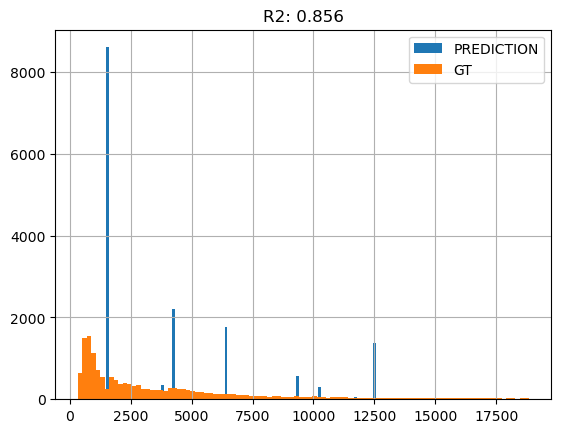

In [222]:
plt.title(f'R2: {str(score_mlp)[:5]}')
plt.hist(y_pred_mlp.reshape(1, -1)[0], bins=100, label='PREDICTION')
plt.hist(y_test.reshape(1, -1)[0], bins=100, label='GT')
plt.legend()
plt.grid();